# Import

In [ ]:
from datetime import datetime, timedelta
from statistics import mean
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import psycopg2
import calendar

# DataBase Connection

In [ ]:
'''conn = psycopg2.connect(
  port='5432',
  host= "shopify-merchant-dump.ccm9mnr5avgs.ap-south-1.rds.amazonaws.com",
  user= "softtouchlenses_4e0b7c925f8444429457581f35678aea",
  password="softtouchlenses_4e0b7c925f8444429457581f35678aea_password",
  database= "softtouchlenses_4e0b7c925f8444429457581f35678aea_db")
conn = psycopg2.connect(
  host='shopify-merchant-dump.ccm9mnr5avgs.ap-south-1.rds.amazonaws.com',
  port='5432',
  user='paakhi_b014108f50994e35ab8fa4e2dc26d612',
  password='paakhi_b014108f50994e35ab8fa4e2dc26d612_password',
  database='paakhi_b014108f50994e35ab8fa4e2dc26d612_db')'''
conn = psycopg2.connect(
    host='shopify-merchant-dump.ccm9mnr5avgs.ap-south-1.rds.amazonaws.com',
    port='5432',
    user='toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c',
    password='toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c_password',
    database='toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c_db'
)

# Extract and Derive Data

In [ ]:
query1 = """select
created_at::date as created,
id as id,
customer_id as user_id,
source_name as ordered_via,
total_price as order_amount,
CASE
        WHEN cancelled_at IS NOT NULL THEN 'Cancelled'
        ELSE 'Delivered'
    END as order_status
from orders;"""

query2 = """select
order_id,
name as product_name,
quantity from
order_line_item;"""

In [ ]:
e=pd.read_sql(query1,conn)
e.columns = ["created", "order_id", "user_id", "order_channel", "order_amount", "order_status"]
e['created'] = pd.to_datetime(e['created'])
#OrderCount, ASP, AOV, GMV, Acquistion Ratio, Repeat Rate

f = pd.read_sql(query2,conn)
f.columns = ["order_id", "product_name", "quantity"]
# f['created'] = pd.to_datetime(f['created'])
OrderSKUMap=f.groupby('order_id').agg(
        SKUs=pd.NamedAgg(column='product_name', aggfunc= 'nunique'),
        Quantity=pd.NamedAgg(column='quantity', aggfunc='sum'),
    ).reset_index()

# Set Data Columns
e['OrderDate']=e['created'].dt.date
e['OrderDate']=pd.to_datetime(e['OrderDate'])
#Delta Columns
e['DeltaDaysinOrders']=(e.groupby('user_id').OrderDate.shift() - e.OrderDate).dt.days.abs()
e['DeltaOrderValues']=(e.groupby('user_id').order_amount.shift() - e.order_amount)
#Analysis Parameters


x1=e.groupby('user_id').agg(
        LastDate=pd.NamedAgg(column='OrderDate', aggfunc= 'max'),
        FirstDate=pd.NamedAgg(column='OrderDate', aggfunc='min'),

    ).reset_index()


e2=e.merge(x1[['user_id','LastDate','FirstDate']], left_on='user_id', right_on='user_id')
e2=e2.merge(OrderSKUMap, left_on='order_id', right_on='order_id', how='left')

e2['TrxnRank'] = e2.groupby('user_id')['OrderDate'].rank(method='first')
# e2=e2[e2['OrderDate']>='2022-01-01']
# e2=e2[e2['OrderDate']<='2022-12-31']


#fetch metrices

e2['New']=0
e2.loc[e2['TrxnRank']==1,'New']=1
e2['Repeat']=0
e2.loc[e2['TrxnRank']>1,'Repeat']=1
e2_copy = e2.copy()
e2 = e2[e2["New"] == 1]

# e2['order_id']=e2['order_id_x']
y2=e2.groupby('OrderDate').agg(
        OrderCounts=pd.NamedAgg(column='order_id', aggfunc= 'count'),
        TotalOrderValue=pd.NamedAgg(column='order_amount', aggfunc='sum'),
        AOV=pd.NamedAgg(column='order_amount', aggfunc='mean'),
    Quantity=pd.NamedAgg(column='Quantity', aggfunc='sum'),
SKUCount=pd.NamedAgg(column='SKUs', aggfunc='sum'),

    ).reset_index()

cancelled_orders = e2[e2['order_status'] == 'Cancelled'].groupby('OrderDate').agg(
    CancellationCount=pd.NamedAgg(column='order_id', aggfunc='count')
).reset_index()

delivered_orders = e2[e2['order_status'] == 'Delivered'].groupby('OrderDate').agg(
    DeliveryCount=pd.NamedAgg(column='order_id', aggfunc='count')
).reset_index()

y3=e2.groupby(['OrderDate', "user_id"]).agg(
        TotalOrderValue=pd.NamedAgg(column='order_amount', aggfunc='sum'),
    Quantity=pd.NamedAgg(column='Quantity', aggfunc='sum'),
SKUCount=pd.NamedAgg(column='SKUs', aggfunc='sum'),
).reset_index()
y3['UserRank']=y3.groupby('user_id')['OrderDate'].rank(method='first')
y3 = y3.groupby('OrderDate').agg(
    NewUserCount=pd.NamedAgg(column='UserRank', aggfunc=lambda x: (x == 1.0).sum())
)

y2 = y2.merge(cancelled_orders, on='OrderDate', how='left')
y2 = y2.merge(delivered_orders, on='OrderDate', how='left')
y2['CancellationCount'].fillna(0, inplace=True)
y2['DeliveryCount'].fillna(0, inplace=True)

y2=y2.merge(y3, left_on='OrderDate', right_on='OrderDate')

ordered_via_values = e2['order_channel'].unique()
for ordered_via in ordered_via_values:
    y2[f'Channel_{ordered_via}'] = 0
for ordered_via in ordered_via_values:
    orders_by_channel = e2[e2['order_channel'] == ordered_via].groupby('OrderDate').size()
    y2[f'Channel_{ordered_via}'] = y2['OrderDate'].map(orders_by_channel).fillna(0)

# y2['NewOrderRatio']=y2['NewTrxns']/y2['OrderCounts']
# y2['RepeatOrderRatio']=y2['RepearTrxns']/y2['OrderCounts']
y2['UnitsperOrder']=y2['Quantity']/y2['OrderCounts']
y2['SKUsperOrder']=y2['SKUCount']/y2['OrderCounts']
y2['ASP']=y2['TotalOrderValue']/y2['Quantity']
y2['CancellationRate']=y2['CancellationCount']/y2['OrderCounts']
# y2["RepeatUserCount"] = y2["ActiveUsersCounts"] - y2["NewUserCount"]

channel_metrics=[]
for ordered_via in ordered_via_values:
    metric = f'Channel_{ordered_via}'
    channel_metrics.append(metric)
y2.columns = ["Order_Date", "Order_Counts", "Total_Order_Value", "AOV", "Total_Quantity", "Products_Count", "Cancelled_Order_Counts", "Delivered_Orders_Counts", "New_User_Counts"] + channel_metrics + ["No_Units_per_Order", "No_Products_per_Order", "ASP", "Calcellation_Rate_(in %)"]

<ipython-input-32-090fc181f1af>:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  e=pd.read_sql(query1,conn)
<ipython-input-32-090fc181f1af>:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  f = pd.read_sql(query2,conn)


In [ ]:
y2

,Order_Date,Order_Counts,Total_Order_Value,AOV,Total_Quantity,Products_Count,Cancelled_Order_Counts,Delivered_Orders_Counts,New_User_Counts,Channel_8085798913,Channel_Created by Shopflo,Channel_web,Channel_4313721,Channel_5482997,No_Units_per_Order,No_Products_per_Order,ASP,Calcellation_Rate_(in %)
0,2020-09-12,1,1.0,1.000000,1,1,0.0,1.0,1,0.0,0.0,0.0,1.0,0.0,1.000000,1.000000,1.000000,0.0
1,2020-09-14,1,661.5,661.500000,1,1,0.0,1.0,1,0.0,0.0,1.0,0.0,0.0,1.000000,1.000000,661.500000,0.0
2,2020-09-18,1,627.5,627.500000,1,1,0.0,1.0,1,0.0,0.0,1.0,0.0,0.0,1.000000,1.000000,627.500000,0.0
3,2020-09-19,17,7735.0,455.000000,17,17,0.0,17.0,17,0.0,0.0,0.0,17.0,0.0,1.000000,1.000000,455.000000,0.0
4,2020-09-20,19,8645.0,455.000000,19,19,0.0,19.0,19,0.0,0.0,0.0,19.0,0.0,1.000000,1.000000,455.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1165,2023-12-04,122,41601.8,340.998361,129,127,0.0,122.0,122,0.0,120.0,2.0,0.0,0.0,1.057377,1.040984,322.494574,0.0
1166,2023-12-05,113,35938.0,318.035398,122,122,0.0,113.0,113,0.0,108.0,5.0,0.0,0.0,1.079646,1.079646,294.573770,0.0
1167,2023-12-06,139,50825.0,365.647482,156,153,0.0,139.0,139,0.0,136.0,3.0,0.0,0.0,1.122302,1.100719,325.801282,0.0
1168,2023-12-07,197,63532.0,322.497462,215,210,0.0,197.0,197,0.0,185.0,12.0,0.0,0.0,1.091371,1.065990,295.497674,0.0


# Acquisition Seasonality

In [ ]:
overall_metrics = ["Order_Date", "Order_Counts", "Total_Order_Value", "AOV", "ASP", "No_Products_per_Order", "No_Units_per_Order", "Cancelled_Order_Counts", "Calcellation_Rate_(in %)"] + channel_metrics
working_df = y2[overall_metrics]

In [ ]:
def day_of_week(df, param):
    col_name = f"Average_{param}"
    df_1 = df[["Order_Date", param]]
    df_1.columns = ["Date", "Value"]
    df_1['DayOfWeek'] = df_1['Date'].dt.strftime('%A')
    custom_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
    df_1['DayOfWeek'] = pd.Categorical(df_1['DayOfWeek'], categories=custom_order, ordered=True)
    result = df_1.groupby('DayOfWeek')['Value'].mean().reset_index()
    result.columns = ["DayOfWeek", col_name]
    m = result[col_name].mean()
    result["Seasonality_Index"] = (result[col_name] - m)*100/m
    x = f"Average_Weekly_{param}"
    result.columns = ["Day_of_the_Week", x, "Seasonality_Index_(in %)"]
    return result

def day_of_month(df, param):
    col_name = f"Average_{param}"
    df_1 = df[["Order_Date", param]]
    df_1.columns = ["Date", "Value"]
    df_1['DayOfMonth'] = df_1['Date'].dt.day
    result = df_1.groupby('DayOfMonth')['Value'].mean().reset_index()
    result.columns = ["DayOfMonth", col_name]
    m = result[col_name].mean()
    result["Seasonality_Index"] = (result[col_name] - m)*100/m
    x = f"Average_Monthly_{param}"
    result.columns = ["Day_of_the_Month", x, "Seasonality_Index_(in %)"]
    return result

def month_of_year(df, param):
    col_name = f"Average_{param}"
    df_1 = df[["Order_Date", param]]
    df_1.columns = ["Date", "Value"]
    df_1['Month'] = df_1['Date'].dt.strftime('%B')
    custom_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    df_1['Month'] = pd.Categorical(df_1['Month'], categories=custom_order, ordered=True)
    result = df_1.groupby('Month')['Value'].mean().reset_index()
    result.columns = ["Month", col_name]
    m = result[col_name].mean()
    result["Seasonality_Index"] = (result[col_name] - m)*100/m
    x = f"Average_Yearly_{param}"
    result.columns = ["Month_of_the_Year", x, "Seasonality_Index_(in %)"]
    return result

In [ ]:
x = day_of_week(working_df, "Order_Counts")

<ipython-input-35-05f64d235528>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['DayOfWeek'] = df_1['Date'].dt.strftime('%A')
<ipython-input-35-05f64d235528>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['DayOfWeek'] = pd.Categorical(df_1['DayOfWeek'], categories=custom_order, ordered=True)


In [ ]:
x

,Day_of_the_Week,Average_Weekly_Order_Counts,Seasonality_Index_(in %)
0,Sunday,38.295181,2.159938
1,Monday,33.797619,-9.838193
2,Tuesday,34.928571,-6.821155
3,Wednesday,40.215569,7.282952
4,Thursday,40.508982,8.065689
5,Friday,36.550898,-2.493279
6,Saturday,38.101796,1.644048


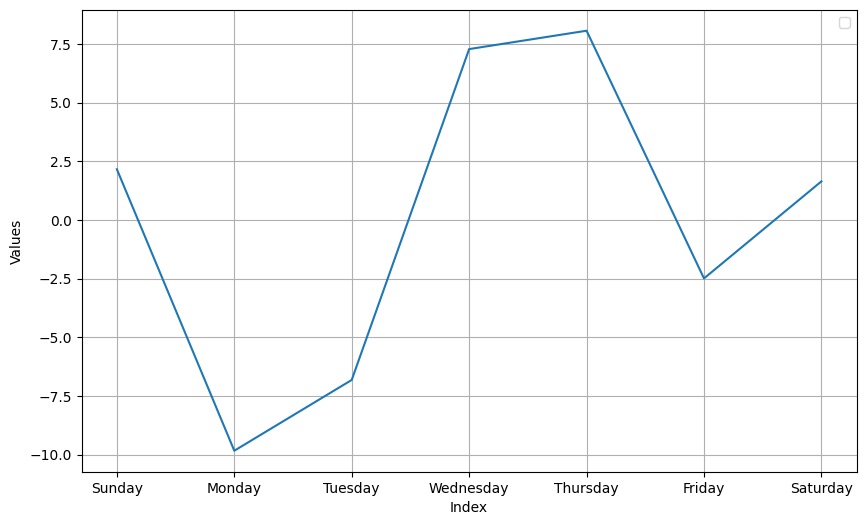

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(x.iloc[:, 0], x.iloc[:, 2])
plt.xlabel('Index')
plt.ylabel('Values')
plt.grid(True)
plt.legend()
plt.show()

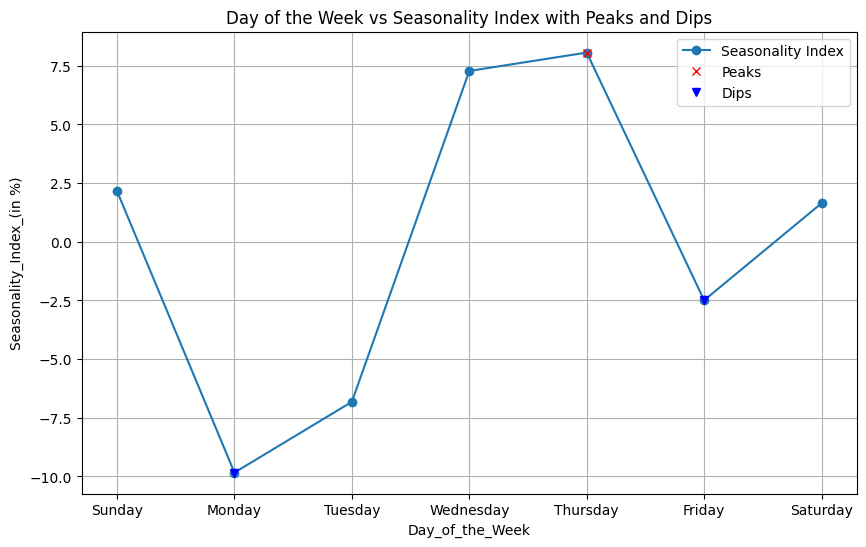

In [ ]:
days_of_week = x[x.columns.tolist()[0]].tolist()
seasonality_index = x[x.columns.tolist()[2]].tolist()

peaks, _ = find_peaks(seasonality_index, distance=1)
dips, _ = find_peaks(-np.array(seasonality_index), distance=1)

plt.figure(figsize=(10, 6))
plt.plot(days_of_week, seasonality_index, marker='o', label='Seasonality Index')
plt.plot(np.array(days_of_week)[peaks], np.array(seasonality_index)[peaks], "rx", label="Peaks")
plt.plot(np.array(days_of_week)[dips], np.array(seasonality_index)[dips], "bv", label="Dips")

plt.title(f'Day of the Week vs Seasonality Index with Peaks and Dips')
plt.xlabel(x.columns.tolist()[0])
plt.ylabel(x.columns.tolist()[2])
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
seasonality_cycles = ["Weekly", "Monthly", "Yearly"]

In [ ]:
metrics = []
cycle = []
peak_counts = []
dip_counts = []
target_metrics = overall_metrics[1:]

for i in range (len(target_metrics)):
    for j in range (len(seasonality_cycles)):
        metric = target_metrics[i]
        current_cycle = seasonality_cycles[j]

        if current_cycle == "Weekly":
            dummy_df = day_of_week(working_df, metric)
        elif current_cycle == "Monthly":
            dummy_df = day_of_month(working_df, metric)
        elif current_cycle == "Yearly":
            dummy_df = month_of_year(working_df, metric)

        seasonality_index = dummy_df.iloc[:, 2].tolist()
        peaks, _ = find_peaks(seasonality_index, distance=1)
        dips, _ = find_peaks(-np.array(seasonality_index), distance=1)

        peak_count = len(peaks)
        dip_count = len(dips)

        metrics.append(metric)
        cycle.append(current_cycle)
        peak_counts.append(peak_count)
        dip_counts.append(dip_count)

view1_peak_dip = pd.DataFrame({"Mertics": metrics, "Seasonality Cycle": cycle, "Peak Count": peak_counts, "Dip Counts": dip_counts})

<ipython-input-35-05f64d235528>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['DayOfWeek'] = df_1['Date'].dt.strftime('%A')
<ipython-input-35-05f64d235528>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['DayOfWeek'] = pd.Categorical(df_1['DayOfWeek'], categories=custom_order, ordered=True)
<ipython-input-35-05f64d235528>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [ ]:
view1_peak_dip

,Mertics,Seasonality Cycle,Peak Count,Dip Counts
0,Order_Counts,Weekly,1,2
1,Order_Counts,Monthly,8,8
2,Order_Counts,Yearly,2,3
3,Total_Order_Value,Weekly,1,2
4,Total_Order_Value,Monthly,10,9
5,Total_Order_Value,Yearly,2,3
6,AOV,Weekly,3,2
7,AOV,Monthly,12,11
8,AOV,Yearly,5,5
9,ASP,Weekly,3,2


In [ ]:
metrics = []
cycle = []
min_values = []
max_values = []
ratios = []
target_metrics = overall_metrics[1:]

for i in range (len(target_metrics)):
    for j in range (len(seasonality_cycles)):
        metric = target_metrics[i]
        print(metric)
        current_cycle = seasonality_cycles[j]

        if current_cycle == "Weekly":
            dummy_df = day_of_week(working_df, metric)
        elif current_cycle == "Monthly":
            dummy_df = day_of_month(working_df, metric)
        elif current_cycle == "Yearly":
            dummy_df = month_of_year(working_df, metric)

        average_values = dummy_df.iloc[:, 1].tolist()
        min_value = min(average_values)
        max_value = max(average_values)
        if min_value == 0:
            average_values_updated = [x for x in average_values if x != 0]
            min_value = min(average_values_updated)
        ratio = max_value/min_value

        metrics.append(metric)
        cycle.append(current_cycle)
        min_values.append(min_value)
        max_values.append(max_value)
        ratios.append(ratio)

view2_peak_dip = pd.DataFrame({"Mertics": metrics, "Seasonality Cycle": cycle, "Dip Value": min_values, "Peak Value": max_values, "Variation Ratio": ratios})

<ipython-input-35-05f64d235528>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['DayOfWeek'] = df_1['Date'].dt.strftime('%A')
<ipython-input-35-05f64d235528>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['DayOfWeek'] = pd.Categorical(df_1['DayOfWeek'], categories=custom_order, ordered=True)
<ipython-input-35-05f64d235528>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

Order_Counts
Order_Counts
Order_Counts
Total_Order_Value
Total_Order_Value
Total_Order_Value
AOV
AOV
AOV
ASP
ASP
ASP
No_Products_per_Order
No_Products_per_Order
No_Products_per_Order
No_Units_per_Order
No_Units_per_Order
No_Units_per_Order
Cancelled_Order_Counts
Cancelled_Order_Counts


<ipython-input-35-05f64d235528>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['Month'] = df_1['Date'].dt.strftime('%B')
<ipython-input-35-05f64d235528>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['Month'] = pd.Categorical(df_1['Month'], categories=custom_order, ordered=True)
<ipython-input-35-05f64d235528>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

Cancelled_Order_Counts
Calcellation_Rate_(in %)
Calcellation_Rate_(in %)
Calcellation_Rate_(in %)
Channel_8085798913
Channel_8085798913
Channel_8085798913
Channel_Created by Shopflo
Channel_Created by Shopflo
Channel_Created by Shopflo
Channel_web
Channel_web
Channel_web
Channel_4313721
Channel_4313721
Channel_4313721
Channel_5482997
Channel_5482997
Channel_5482997


<ipython-input-35-05f64d235528>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['DayOfWeek'] = df_1['Date'].dt.strftime('%A')
<ipython-input-35-05f64d235528>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['DayOfWeek'] = pd.Categorical(df_1['DayOfWeek'], categories=custom_order, ordered=True)
<ipython-input-35-05f64d235528>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [ ]:
view2_peak_dip.round(2)

,Mertics,Seasonality Cycle,Dip Value,Peak Value,Variation Ratio
0,Order_Counts,Weekly,33.80,40.51,1.20
1,Order_Counts,Monthly,28.19,54.92,1.95
2,Order_Counts,Yearly,19.52,56.03,2.87
3,Total_Order_Value,Weekly,21401.80,24319.42,1.14
4,Total_Order_Value,Monthly,18320.41,28623.78,1.56
5,Total_Order_Value,Yearly,16129.55,30676.28,1.90
6,AOV,Weekly,854.20,931.05,1.09
7,AOV,Monthly,797.46,1141.34,1.43
8,AOV,Yearly,720.13,1094.49,1.52
9,ASP,Weekly,628.33,687.97,1.09


In [ ]:
view2_peak_dip["Variation Ratio"].nlargest(5)

22    295.764466
35     64.888889
23     53.995714
34     18.103448
20     15.333333
Name: Variation Ratio, dtype: float64

In [ ]:
metrics = []
cycle = []
above_average_counts = []
below_average_counts = []
target_metrics = overall_metrics[1:]

for i in range (len(target_metrics)):
    for j in range (len(seasonality_cycles)):
        metric = target_metrics[i]
        current_cycle = seasonality_cycles[j]

        if current_cycle == "Weekly":
            dummy_df = day_of_week(working_df, metric)
        elif current_cycle == "Monthly":
            dummy_df = day_of_month(working_df, metric)
        elif current_cycle == "Yearly":
            dummy_df = month_of_year(working_df, metric)

        seasonality_index = dummy_df.iloc[:, 2].tolist()
        m = mean(seasonality_index)

        above_average = [x for x in seasonality_index if x >= m]
        below_average = [x for x in seasonality_index if x < m]

        above_average_count = len(above_average)
        below_average_count = len(below_average)

        metrics.append(metric)
        cycle.append(current_cycle)
        above_average_counts.append(above_average_count)
        below_average_counts.append(below_average_count)

view3_peak_dip = pd.DataFrame({"Mertics": metrics, "Seasonality Cycle": cycle, "Above Average Count": above_average_counts, "Below Average Count": below_average_counts})
view3_peak_dip["Above Average Counts Percentage"] = (view3_peak_dip["Above Average Count"] * 100) / (view3_peak_dip["Above Average Count"] + view3_peak_dip["Below Average Count"])
view3_peak_dip["Below Average Counts Percentage"] = (view3_peak_dip["Below Average Count"] * 100) / (view3_peak_dip["Above Average Count"] + view3_peak_dip["Below Average Count"])

<ipython-input-35-05f64d235528>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['DayOfWeek'] = df_1['Date'].dt.strftime('%A')
<ipython-input-35-05f64d235528>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['DayOfWeek'] = pd.Categorical(df_1['DayOfWeek'], categories=custom_order, ordered=True)
<ipython-input-35-05f64d235528>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [ ]:
view3_peak_dip.round(2)

,Mertics,Seasonality Cycle,Above Average Count,Below Average Count,Above Average Counts Percentage,Below Average Counts Percentage
0,Order_Counts,Weekly,4,3,57.14,42.86
1,Order_Counts,Monthly,12,19,38.71,61.29
2,Order_Counts,Yearly,6,6,50.00,50.00
3,Total_Order_Value,Weekly,4,3,57.14,42.86
4,Total_Order_Value,Monthly,14,17,45.16,54.84
5,Total_Order_Value,Yearly,5,7,41.67,58.33
6,AOV,Weekly,4,3,57.14,42.86
7,AOV,Monthly,11,20,35.48,64.52
8,AOV,Yearly,7,5,58.33,41.67
9,ASP,Weekly,4,3,57.14,42.86


# Number of Days for New to Repeat Conversion

In [ ]:
gap_new_to_repeat = e2_copy.copy()
gap_new_to_repeat["Gap_between_New_to_Repeat_Trxn_Days"] = -1
for i in range (len(gap_new_to_repeat[gap_new_to_repeat["TrxnRank"] == 2])):
    # if gap_new_to_repeat["TrxnRank"][i] == 2:
    u_id = gap_new_to_repeat["user_id"][i]
    date = gap_new_to_repeat["OrderDate"][i]
    del_days = date - gap_new_to_repeat[(gap_new_to_repeat["user_id"] == u_id) & (gap_new_to_repeat["TrxnRank"] == 1)]["OrderDate"]
    idx = gap_new_to_repeat[(gap_new_to_repeat["user_id"] == u_id) & (gap_new_to_repeat["TrxnRank"] == 1)].index.values[0]
    # print(e2.iloc[idx, 16])
    gap_new_to_repeat.at[idx, "Gap_between_New_to_Repeat_Trxn_Days"] = int(del_days.to_list()[0].days)
    # print(e2.iloc[idx, 16])
gap_new_to_repeat.insert(17, "New_To_Repeat_Conversion_Month", "")

In [ ]:
gap_new_to_repeat

,created,order_id,user_id,order_channel,order_amount,order_status,OrderDate,DeltaDaysinOrders,DeltaOrderValues,LastDate,FirstDate,SKUs,Quantity,TrxnRank,New,Repeat,Gap_between_New_to_Repeat_Trxn_Days,New_To_Repeat_Conversion_Month
0,2023-12-08,5341764845706,6.377996e+12,Created by Shopflo,299.0,Delivered,2023-12-08,NaN,NaN,2023-12-08,2022-12-03,1,1,2.0,0,1,-1,
1,2022-12-03,4904078966922,6.377996e+12,8085798913,440.0,Delivered,2022-12-03,370.0,-141.0,2023-12-08,2022-12-03,2,2,1.0,1,0,0,
2,2023-12-08,5341763338378,6.935222e+12,Created by Shopflo,224.0,Delivered,2023-12-08,NaN,NaN,2023-12-08,2023-12-08,1,1,1.0,1,0,0,
3,2023-12-08,5341763010698,6.935222e+12,Created by Shopflo,828.0,Delivered,2023-12-08,NaN,NaN,2023-12-08,2023-12-08,2,2,1.0,1,0,0,
4,2023-12-08,5341750689930,6.704616e+12,Created by Shopflo,598.0,Delivered,2023-12-08,NaN,NaN,2023-12-08,2023-08-10,1,2,3.0,0,1,-1,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61530,2020-09-19,2423432904842,3.562180e+12,4313721,455.0,Delivered,2020-09-19,NaN,NaN,2020-09-19,2020-09-19,1,1,1.0,1,0,-1,
61531,2020-09-19,2423380213898,3.562087e+12,4313721,455.0,Delivered,2020-09-19,NaN,NaN,2020-09-19,2020-09-19,1,1,1.0,1,0,-1,
61532,2020-09-19,2423350395018,3.562070e+12,4313721,455.0,Delivered,2020-09-19,NaN,NaN,2020-09-19,2020-09-19,1,1,1.0,1,0,-1,
61533,2020-09-19,2423337713802,3.562040e+12,4313721,455.0,Delivered,2020-09-19,NaN,NaN,2020-09-19,2020-09-19,1,1,1.0,1,0,-1,


In [ ]:
for i in range (len(gap_new_to_repeat)):
    if gap_new_to_repeat.iloc[i, 16] > -1 and gap_new_to_repeat.iloc[i, 16] <=30:
        gap_new_to_repeat.iloc[i, 17] = "1 Month"
    elif gap_new_to_repeat.iloc[i, 16] > 30 and gap_new_to_repeat.iloc[i, 16] <=90:
        gap_new_to_repeat.iloc[i, 17] = "3 Month"
    elif gap_new_to_repeat.iloc[i, 16] > 90 and gap_new_to_repeat.iloc[i, 16] <=180:
        gap_new_to_repeat.iloc[i, 17] = "6 Month"
    elif gap_new_to_repeat.iloc[i, 16] >180:
        gap_new_to_repeat.iloc[i, 17] = "6+ Month"

In [ ]:
gap_new_to_repeat[gap_new_to_repeat["Repeat"] == 1]

,created,order_id,user_id,order_channel,order_amount,order_status,OrderDate,DeltaDaysinOrders,DeltaOrderValues,LastDate,FirstDate,SKUs,Quantity,TrxnRank,New,Repeat,Gap_between_New_to_Repeat_Trxn_Days,New_To_Repeat_Conversion_Month
0,2023-12-08,5341764845706,6.377996e+12,Created by Shopflo,299.0,Delivered,2023-12-08,NaN,NaN,2023-12-08,2022-12-03,1,1,2.0,0,1,-1,
4,2023-12-08,5341750689930,6.704616e+12,Created by Shopflo,598.0,Delivered,2023-12-08,NaN,NaN,2023-12-08,2023-08-10,1,2,3.0,0,1,-1,
5,2023-08-17,5183619104906,6.704616e+12,Created by Shopflo,299.0,Delivered,2023-08-17,113.0,299.0,2023-12-08,2023-08-10,1,1,2.0,0,1,-1,
8,2023-12-08,5341737910410,6.801344e+12,Created by Shopflo,324.0,Delivered,2023-12-08,NaN,NaN,2023-12-08,2023-10-09,1,1,6.0,0,1,-1,
9,2023-11-29,5330824298634,6.801344e+12,Created by Shopflo,324.0,Delivered,2023-11-29,9.0,0.0,2023-12-08,2023-10-09,1,1,5.0,0,1,-1,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61180,2020-09-24,2427368931466,3.568243e+12,4313721,165.0,Delivered,2020-09-24,0.0,0.0,2020-09-24,2020-09-24,1,1,3.0,0,1,-1,
61181,2020-09-24,2427293139082,3.568243e+12,4313721,165.0,Delivered,2020-09-24,0.0,0.0,2020-09-24,2020-09-24,1,1,4.0,0,1,-1,
61217,2020-09-24,2427141881994,3.568035e+12,4313721,165.0,Delivered,2020-09-24,0.0,0.0,2020-09-24,2020-09-24,1,1,2.0,0,1,-1,
61226,2020-09-24,2427133362314,3.568027e+12,4313721,165.0,Delivered,2020-09-24,0.0,0.0,2020-09-24,2020-09-24,1,1,2.0,0,1,-1,


In [ ]:
gap_new_to_repeat_days = gap_new_to_repeat[gap_new_to_repeat["Gap_between_New_to_Repeat_Trxn_Days"] != -1][["Gap_between_New_to_Repeat_Trxn_Days"]]

In [ ]:
gap_new_to_repeat_days

,Gap_between_New_to_Repeat_Trxn_Days
1,0
2,0
3,0
6,0
7,0
...,...
8433,0
8434,0
8435,0
8436,0


In [ ]:
data = gap_new_to_repeat_days['Gap_between_New_to_Repeat_Trxn_Days']
counts, bin_edges = np.histogram(data, bins=10)
histogram_table = pd.DataFrame({'Number of Days Between First and Second Purchases': bin_edges[:-1], 'Customer Counts': counts})
histogram_table

,Number of Days Between First and Second Purchases,Customer Counts
0,0.0,4976
1,32.4,8
2,64.8,6
3,97.2,1
4,129.6,3
5,162.0,2
6,194.4,0
7,226.8,0
8,259.2,3
9,291.6,1


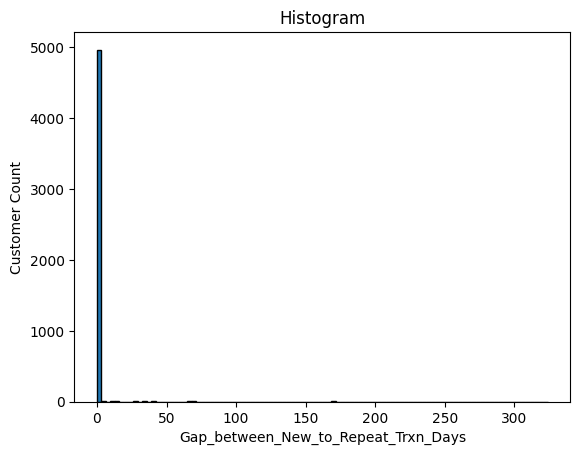

In [ ]:
plt.hist(gap_new_to_repeat_days['Gap_between_New_to_Repeat_Trxn_Days'], bins=100, edgecolor='black')
plt.xlabel('Gap_between_New_to_Repeat_Trxn_Days')
plt.ylabel('Customer Count')
plt.title('Histogram')
plt.show()

In [ ]:
gap_new_to_repeat_days['Buckets'] = pd.cut(gap_new_to_repeat_days['Gap_between_New_to_Repeat_Trxn_Days'], bins=10, precision=0, include_lowest=False)
decile_table = gap_new_to_repeat_days['Buckets'].value_counts().reset_index()#.sort_values(by = "count", ascending = False)
decile_table.set_index("Buckets", inplace = True)
decile_table = decile_table.sort_values(by="Buckets")

labels = decile_table.index.tolist()
user_counts = decile_table["count"].tolist()
bin_df = pd.DataFrame({'Days Gap Between Transactions (Lower Limit)': [label.left for label in labels],
                       'Days Gap Between Transactions (Upper Limit)': [label.right for label in labels],
                       'Customer Count': user_counts})
bin_df[['Days Gap Between Transactions (Lower Limit)', 'Days Gap Between Transactions (Upper Limit)']] = bin_df[['Days Gap Between Transactions (Lower Limit)', 'Days Gap Between Transactions (Upper Limit)']].apply(lambda x: x.clip(lower=0))
bin_df["No of Days Gap Between Transactions"] = bin_df[["Days Gap Between Transactions (Lower Limit)", "Days Gap Between Transactions (Upper Limit)"]].astype("str").apply("-".join, axis=1)

for i in range(len(bin_df)):
    x = str(bin_df.iloc[i, 3])
    a = (x.split("-")[0])[:-2]
    b = (x.split("-")[1])[:-2]
    x = a + " - " + b + " Days"
    bin_df.iloc[i, 3] = x
bin_df = bin_df[["No of Days Gap Between Transactions", "Customer Count"]]

KeyError: ignored

In [ ]:
bin_df = bin_df.T
bin_df.columns = bin_df.iloc[0]
bin_df = bin_df.iloc[1:]
bin_df

# Monthly Conversion Rate

In [ ]:
e2_copy = e2.copy()
e2_copy["MonthYear"] = e2_copy["created"].dt.strftime("%Y-%m")
e2_copy_1 = e2_copy.copy()
new_users_1 = e2_copy[e2_copy['New'] == 1][['MonthYear', 'user_id']]
e2_copy_2 = e2_copy_1[['user_id', 'MonthYear']]

In [ ]:
merged_df = pd.merge(new_users_1, e2_copy_2, on=['user_id', 'MonthYear'], how='inner')
user_counts = merged_df.groupby(['user_id', 'MonthYear']).size().reset_index(name='count')
new_user_counts_ordered_again = {(row['user_id'], row['MonthYear']): row['count'] for _, row in user_counts.iterrows()}

In [ ]:
filtered_data = {key: value for key, value in new_user_counts_ordered_again.items() if value != 1}
sum_dict = {}

for key, _ in filtered_data.items():
    _, year_month = key
    if year_month in sum_dict:
        sum_dict[year_month] += 1  # Increment the count by one
    else:
        sum_dict[year_month] = 1

sorted_result_1 = dict(sorted(sum_dict.items()))

In [ ]:
new_users_df = e2_copy_1[e2_copy_1['New'] == 1]
new_users_per_month = new_users_df.groupby('MonthYear').size().reset_index(name='NewUserCount')
result_dict = dict(zip(new_users_per_month["MonthYear"], new_users_per_month["NewUserCount"]))

In [ ]:
result_dict_1 = {key: sum_dict[key] / result_dict[key] for key in sum_dict}
sorted_result = dict(sorted(result_dict_1.items()))

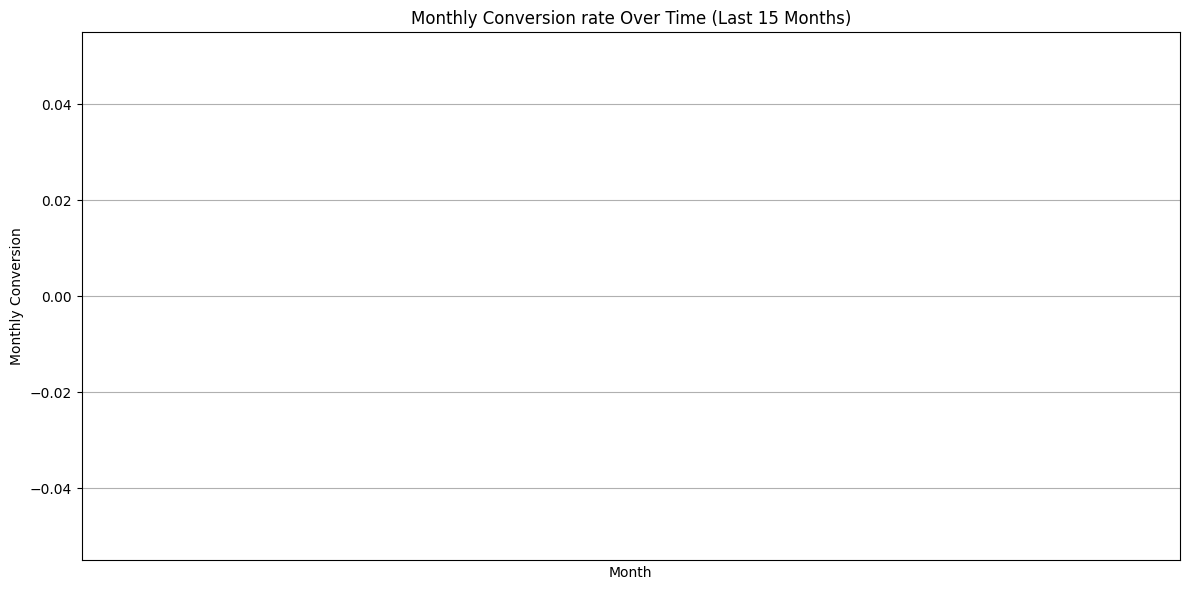

In [ ]:
df = pd.DataFrame(list(sorted_result.items()), columns=['Month', 'Decimal'])
df['Month'] = pd.to_datetime(df['Month'])
df = df.sort_values(by='Month')
df = df[-16:-1]
df['Decimal'] = df['Decimal'] * 100

plt.figure(figsize=(12, 6))
plt.plot(df['Month'], df['Decimal'], marker='o', linestyle='-', color='b')
plt.title('Monthly Conversion rate Over Time (Last 15 Months)')
plt.xlabel('Month')
plt.ylabel('Monthly Conversion')
plt.xticks(df['Month'], rotation=45, ha='right')  # Set x-axis ticks to include all weeks
plt.grid(True)
plt.tight_layout()
plt.show()

# Fixed Seasonality

In [ ]:
festivals = {
  "Diwali": "2022-10-24",
  "Holi": "2022-03-18",
  "Ganesh Chaturthi": "2022-08-31",
  "Dussehra": "2022-10-05",
  "Independence Day": "2022-08-15",
  "Republic Day": "2022-01-26",
  "Gandhi Jayanti": "2022-10-02",
  "Christmas Day": "2022-12-25",
  "New Year's Day": "2022-01-01"
}

In [ ]:
from prophet import Prophet

In [ ]:
def seasonality(df):
    m = Prophet(weekly_seasonality = True, yearly_seasonality = True, seasonality_mode="multiplicative")
    m.add_seasonality(name='monthly', period=30.5, fourier_order=10)
    m.fit(df)
    future = m.make_future_dataframe(periods=1825)
    forecast = m.predict(future)
    fig = m.plot_components(forecast)

    last_date = df['ds'].max()
    forecast['date'] = pd.to_datetime(forecast['ds'])
    previous_week_end = last_date - pd.DateOffset(weeks=1)
    previous_week_start = last_date - pd.DateOffset(weeks=1, days=6)
    previous_week_data = forecast[(forecast['date'] >= previous_week_start) & (forecast['date'] <= previous_week_end)]
    previous_week_avg = previous_week_data['yhat'].mean()
    previous_week_dates = f"{previous_week_start} - {previous_week_end}"

    forecast['date'] = pd.to_datetime(forecast['ds'])
    next_week_start = last_date + pd.DateOffset(weeks=1)
    next_week_end = last_date + pd.DateOffset(weeks=1, days=6)
    next_week_data = forecast[(forecast['date'] >= next_week_start) & (forecast['date'] <= next_week_end)]
    next_week_avg = next_week_data['yhat'].mean()
    next_week_dates = f"{next_week_start} - {next_week_end}"
    return previous_week_avg, next_week_avg, previous_week_dates, next_week_dates, forecast[['ds', 'yhat']]

def next_holiday_sales_pred(df, forecast, param):
    festival_name, festival_week_prediction, seasonality_impact = [], [], []
    flag = 0
    if "Ratio" in param or "Rate" in param  or param == "AOV" or param == "ASP" or "per" in param:
      flag = 1
    for i in range (4):
        festival = upcoming_festivals[i][0]
        festival_date = upcoming_festivals[i][1]
        festival_week_start = festival_date - timedelta(days = 3)
        festival_week_start = datetime.combine(festival_week_start, datetime.min.time())
        festival_week_end = festival_date + timedelta(days = 3)
        festival_week_end = datetime.combine(festival_week_end, datetime.min.time())
        festival_last_week_start = festival_date - timedelta(days = 10)
        festival_last_week_start = datetime.combine(festival_last_week_start, datetime.min.time())
        prediction_festival_last_week_data =  forecast[(forecast['ds'] >= festival_last_week_start) & (forecast['ds'] < festival_week_start)]
        prediction_festival_week_data =  forecast[(forecast['ds'] >= festival_week_start) & (forecast['ds'] < festival_week_end)]
        if flag == 1:
            prediction_festival_week = float(format(np.mean(prediction_festival_week_data['yhat'])))
            prediction_festival_last_week = float(format(np.mean(prediction_festival_last_week_data['yhat'])))
        else:
            prediction_festival_week = float(format(math.ceil(sum(prediction_festival_week_data['yhat']))))
            prediction_festival_last_week = float(format(math.ceil(sum(prediction_festival_last_week_data['yhat']))))

        if "Ratio" in param and prediction_festival_week >= 1 and prediction_festival_last_week >= 1:
            festival = upcoming_festivals[i][0]
            festival_date = festivals[festival]
            festival_date = datetime.strptime(festival_date, "%Y-%m-%d").date()
            festival_week_start = festival_date - timedelta(days = 3)
            festival_week_start = datetime.combine(festival_week_start, datetime.min.time())
            festival_week_end = festival_date + timedelta(days = 3)
            festival_week_end = datetime.combine(festival_week_end, datetime.min.time())
            festival_last_week_start = festival_date - timedelta(days = 10)
            festival_last_week_start = datetime.combine(festival_last_week_start, datetime.min.time())
            prediction_festival_last_week_data =  df[(df['ds'] >= festival_last_week_start) & (df['ds'] < festival_week_start)]
            prediction_festival_week_data =  df[(df['ds'] >= festival_week_start) & (df['ds'] < festival_week_end)]
            prediction_festival_week = float(format(np.mean(prediction_festival_week_data['y'])))
            prediction_festival_last_week = float(format(np.mean(prediction_festival_last_week_data['y'])))

        if "Rate" in param and prediction_festival_week >= 100 and prediction_festival_last_week >= 100:
            festival = upcoming_festivals[i][0]
            festival_date = festivals[festival]
            festival_date = datetime.strptime(festival_date, "%Y-%m-%d").date()
            festival_week_start = festival_date - timedelta(days = 3)
            festival_week_start = datetime.combine(festival_week_start, datetime.min.time())
            festival_week_end = festival_date + timedelta(days = 3)
            festival_week_end = datetime.combine(festival_week_end, datetime.min.time())
            festival_last_week_start = festival_date - timedelta(days = 10)
            festival_last_week_start = datetime.combine(festival_last_week_start, datetime.min.time())
            prediction_festival_last_week_data =  df[(df['ds'] >= festival_last_week_start) & (df['ds'] < festival_week_start)]
            prediction_festival_week_data =  df[(df['ds'] >= festival_week_start) & (df['ds'] < festival_week_end)]
            prediction_festival_week = float(format(np.mean(prediction_festival_week_data['y'])))
            prediction_festival_last_week = float(format(np.mean(prediction_festival_last_week_data['y'])))
        if prediction_festival_last_week != 0:
          WoW_relation = ((prediction_festival_week - prediction_festival_last_week) * 100) / prediction_festival_last_week
        else:
          WoW_relation = 100
        WoW_relation = round(WoW_relation, 2)
        festival_name.append(festival)
        festival_week_prediction.append(round(prediction_festival_week, 2))
        seasonality_impact.append(WoW_relation)
    df = pd.DataFrame({"Upcoming Event": festival_name, f"Predicted Value of {param} for the Festival Week": festival_week_prediction, "Seasonality Impact (Week on Week)": seasonality_impact})
    return df

def holiday(df, festivals, parameter, start=-1, end=-1):
    if start == -1 and end == -1:
        df['Order_Date'] = pd.to_datetime(df['Order_Date'])
        end = df['Order_Date'].max()
        start = df["OrdeR_Date"].min()
    start = datetime.strptime("start", "%Y-%m-%d")
    end = datetime.strptime("end", "%Y-%m-%d")
    start_year = start.year
    end_year = end.year

    years = [x for x in range (start_year, end_year+1)]
    updated_festivals = {}
    for year in years:
      for festival, date_str in festivals.items():
          date_object = datetime.strptime(date_str, "%Y-%m-%d")
          updated_date_str = f"{year:04d}-{date_object.month:02d}-{date_object.day:02d}"
          updated_festivals[f"{festival}_{year}"] = updated_date_str

    filtered_festivals = {}

    for festival, date_str in updated_festivals.items():
        festival_date = datetime.strptime(date_str, '%Y-%m-%d')
        if start <= festival_date <= end:
            filtered_festivals[festival] = date_str

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpo6n1zbfj/wwereibd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpo6n1zbfj/hbke418x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35189', 'data', 'file=/tmp/tmpo6n1zbfj/wwereibd.json', 'init=/tmp/tmpo6n1zbfj/hbke418x.json', 'output', 'file=/tmp/tmpo6n1zbfj/prophet_modeluu5kjxke/prophet_model-20231208123053.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:30:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:30:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


NameError: ignored

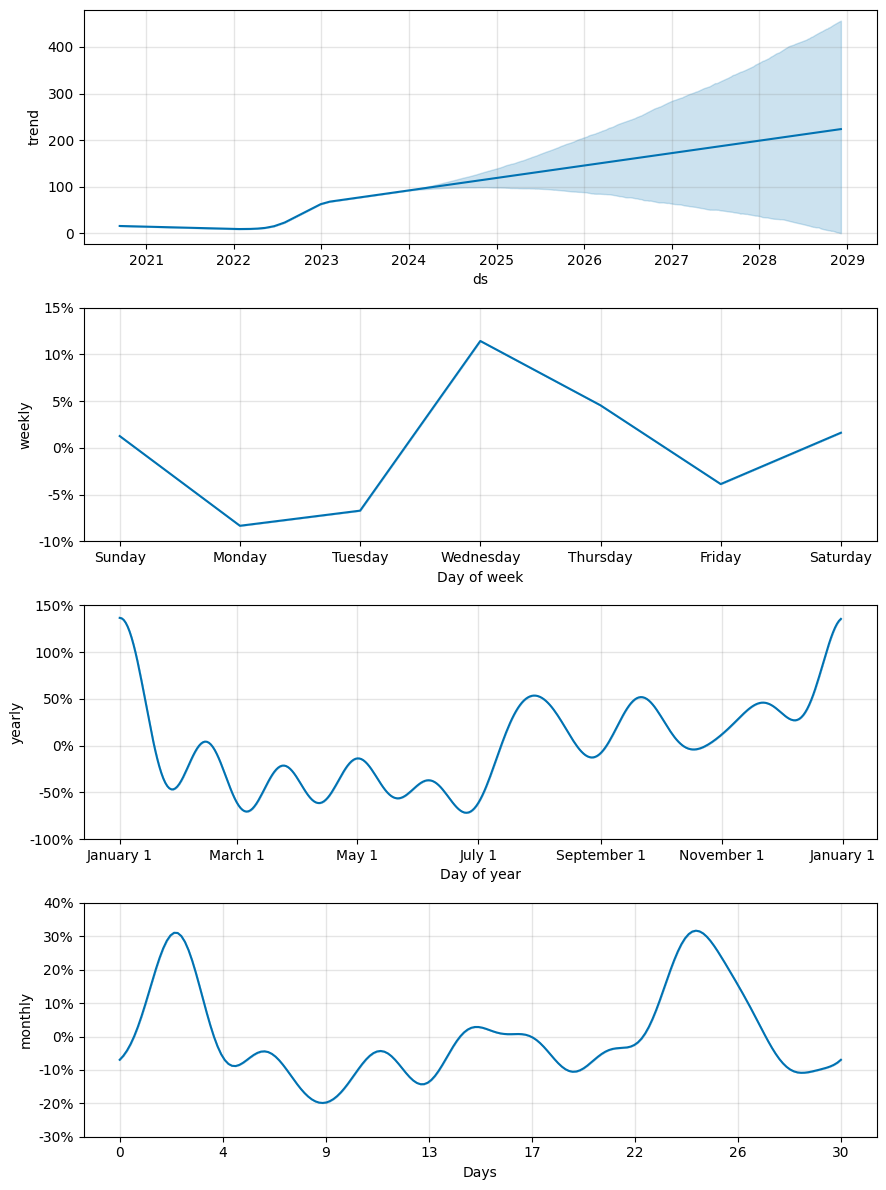

In [ ]:
import logging
logging.captureWarnings(True)
parameter = "Order_Counts"
df = y2[["Order_Date", parameter]]
df_prophet = df.copy()
df_prophet.columns = ["ds", "y"]
previous_week_avg, next_week_avg, previous_week_dates, next_week_dates, forecast = seasonality(df_prophet)
next_holiday = next_holiday_sales_pred(df, forecast, parameter)
df, festivals = holiday(df, festivals, parameter, start='2021-08-01', end='2023-08-01')
print("="*140)